In [1]:
# MY SIMULATION 
import itertools
%matplotlib inline
import os
import random 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
# from vertex_model.run_select_nosaveinfo import run_simulation_INM, definecolors, run_simulation_no_INM
import itertools
import numpy as np
import matplotlib.pyplot as plt
import vertex_model as model
import vertex_model.initialisation as init
import vertex_model.characterization as crt
from vertex_model.forces import TargetArea, Tension, Perimeter, Pressure
import os
import seaborn as sns
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore') #Don't show warnings
#from Gobal_Constant import dt, viscosity, t_G1, t_G2, t_S, A_c, J, pos_d, T1_eps, P, microns, time_hours, expansion_constant #file with necessary constants
from vertex_model.run_select import save_data
sns.set_style("whitegrid")
from scipy.spatial import Delaunay
import math

In [32]:
#Global constants
#Global constants
dt=0.001            #time step
viscosity= 0.02  #viscosity*dv/dt = F
P= 0.0
expansion_constant = 1
Number_simulations = 50
K=1.0 #area elasticity
G= 0.04 #contractility of the cell
L=0.075 #line tensions
L=0.1
Lambda_0 = 0.68 #Line tensions can be reduced by increasing cell-cell adhesion or reducing actin- myosin contractility
t_end = 15
area_dimension= 177 #np.pi*(15/2.0)**2 #15 micrometros de diámetro

In [5]:
# run simulation
def run(simulation,N_step,skip):
    N_step = math.floor(N_step)
    skip = math.floor(skip)
    iter =  itertools.islice(simulation,0,N_step,skip)
    return [cells.copy() for cells in itertools.islice(simulation,0,N_step,skip)]

#simulation without division
def basic_simulation(cells,force,dt=dt,T1_eps=0.04):
    expansion = np.array([0.0,0.0])
    while True:
        cells.mesh , number_T1 = cells.mesh.transition(T1_eps)
        F = force(cells)/viscosity
        dv = dt*model.sum_vertices(cells.mesh.edges,F) 
        if hasattr(cells.mesh.geometry,'width'):
            expansion[0] = expansion_constant*np.average(F[0]*cells.mesh.vertices[0])*dt/(cells.mesh.geometry.width**2)
        if hasattr(cells.mesh.geometry,'height'): #Cylinder mesh doesn't have 'height' argument
            expansion[1] = np.average(F[1]*cells.mesh.vertices[1])*dt/(cells.mesh.geometry.height**2)
        cells.mesh = cells.mesh.moved(dv).scaled(1.0+expansion)
        yield cells
def basic_simulation2(cells,force,dt=dt,T1_eps=0.04):
    expansion = np.array([0.0,0.0])
    while True:
#         print cells.properties['parent_group']
        cells.mesh , number_T1, edg_rem = cells.mesh.transition(T1_eps)
#         cells.properties['Gamma'][cells.mesh.face_ids == 50]=np.array([0.0])
        F = force(cells)/viscosity
#         expansion = 0.05*np.average(F*cells.mesh.vertices,1)*dt
        dv = dt*model.sum_vertices(cells.mesh.edges,F) 
#         cells.mesh = cells.mesh.moved(dv).scaled(1.0+ expansion)
        if hasattr(cells.mesh.geometry,'width'):
            expansion[0] = expansion_constant*np.average(F[0]*cells.mesh.vertices[0])*dt/(cells.mesh.geometry.width**2)
        if hasattr(cells.mesh.geometry,'height'): #Cylinder mesh doesn't have 'height' argument
            expansion[1] = np.average(F[1]*cells.mesh.vertices[1])*dt/(cells.mesh.geometry.height**2)
        cells.mesh = cells.mesh.moved(dv).scaled(1.0+expansion)
        yield cells

In [28]:
def definecolors(cells):
    peach = '#eed5b7'
    light_blue ='#87cefa'
    pink = '#ffc0cb'
    light_green = '#98fb98'
    import matplotlib.colors as colors
    vv=sns.color_palette("hls", 10)
    v=[colors.rgb2hex(colorrgb) for colorrgb in vv]
    palette = np.array([light_green, pink,light_green,'g','r','g','m','c','',peach])
    palette = np.array([v[0],v[1],v[1], v[1],v[4],v[5],v[6],v[7],v[8],v[9],peach])
    colors = cells.properties['parent_group']
    return palette[colors]

In [57]:
# mesh parameters
noise =0
ncellup = 20
ncellacross = 20
ncells = ncellacross*ncellup

In [33]:
def simulation(mesh, id_ecad_cells):
    history_10={}
    #Global constants
    dt=0.001            #time step
    viscosity= 0.02  #viscosity*dv/dt = F
    P= 0.0
    K=1.0 #area elasticity
    G= 0.04 #contractility of the cell
    L=0.075 #line tensions
    L=0.1
    Lambda_0 = 0.68 #Line tensions can be reduced by increasing cell-cell adhesion or reducing actin- myosin contractility
    t_end = 5
    area_dimension= 177 #np.pi*(15/2.0)**2 #15 micrometros de diámetro
    for i in range(1):
        #run simulation with the choosen parameters
        rand =  np.random.RandomState() #random number to choose Lambda
        params = [K,G,L]  # K=x[0],G=x[1],L=x[2]
        cells = model.Cells(mesh,properties={'K':K,'Gamma':G,'P':0.0,'boundary_P':P,'Lambda':L, 'Lambda_boundary':0.5, 'A0':1.0})
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        step = int(50/dt)
        history_init_10= run(basic_simulation2(cells,force),step,int(1/dt)) 
        expansion_constant = 1
        cells = history_init_10[-1].copy()
        cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
        if id_ecad_cells != []:
            cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in id_ecad_cells])[1]] = 1
        cells.properties['Gamma']= np.array([G,0])[cells.properties['parent_group']]
        cells.properties['Lambda']= np.array([L,Lambda_0])[cells.properties['parent_group']]
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        N_Step = math.floor(t_end/dt)
        history_10[i]= run(basic_simulation2(cells,force),N_Step,.010/dt) 
        #save_data(i,history_10[i],'cells10')
    return history_10

In [100]:
history_10={}
#ids_Gamma0 = random.sample(range(1, 100), 10)
ecad_cells = int(0 * ncells)
l = range(ncells)
id_ecad_cells = random.sample(l, ecad_cells)
ids_Gamma0 = [0] #las q tienen menos ecadherina
hex_centres = init.hexagonal_centres_nbp(22,22, 0, rand= np.random.RandomState())
# create a voronoi mesh with those centres 
mesh = init.toroidal_ic_mesh(hex_centres)
a = simulation(mesh, id_ecad_cells)

IndexError: index 1936 is out of bounds for axis 1 with size 1936

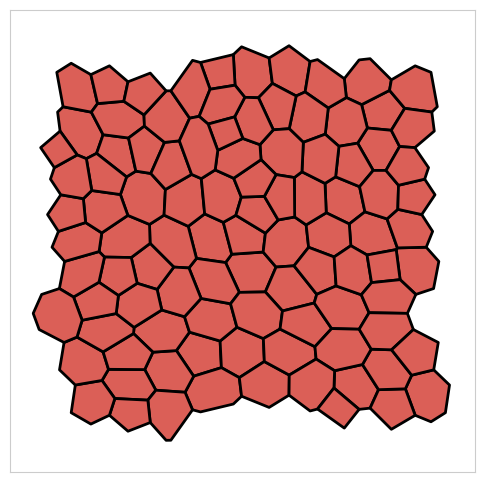

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
i=0
hh = history_10[i]
for cells in hh:
    #ids_nofronter = [1,15,30,6,98, 23,42,56,68,71]
    #cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_nofronter])[1]] = 1
    cells.properties['color'] = definecolors(cells)
    cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #ids_Gamma0 = [1,15,30,6,98,23,42,56,68,71]
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_Gamma0])[1]] = 1
# definition of the frame for the interactive video
history_10_plot = hh[0:40]#+history1
fig=plt.figure()
fig.set_size_inches(6,6);
ax = fig.gca()
# initialization function: plot the background of each frame
def init_fig():
    ax = plt.figure();
    return (ax,)
# animation function. This is called sequentially
def animate_fig(i):
    cells_array=history_10_plot
    v_max = np.max((np.max(cells_array[-1].mesh.vertices), np.max(cells_array[0].mesh.vertices)))
    size = 2.0*v_max
    cells= history_10_plot[i]
    return model.draw(cells,ax,size)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,animate_fig, init_func=init_fig,
                               frames=(len(history_10_plot)))
HTML(anim.to_html5_video())

# Time extrusion calculation


I dont know if there is already a specific function to compute it but the way i do it is checking when
all cells with no ecadherine reach a perimimter of value 0 bc it means that they are no longer in the tissue 

In [11]:
def t_extrusion(hh, ecad_cells): 
    t= 0
    cells_extrused = 0
    for s in hh: 
        m = s.mesh
        if any(cell == 0 for cell in m.perimeter):
            cells_extrused = cells_extrused +1 
        t = t+1
        if cells_extrused == ecad_cells:
            break
    return t   

In [85]:
t_extrusion(hh, ecad_cells)

17

In [36]:
dt=0.001            #time step
viscosity= 0.02  #viscosity*dv/dt = F
P= 0.0
K=1.0 #area elasticity
G= 0.04 #contractility of the cell
L=0.075 #line tensions
L=0.1
Lambda_0 = 0.68 #Line tensions can be reduced by increasing cell-cell adhesion or reducing actin- myosin contractility
t_end = 15
area_dimension= 177 
#ids_Gamma0 = random.sample(range(1, 100), 10)
noise =0
ncellup = 10
ncellacross = 10
ncells = ncellacross*ncellup
ecad_cells = int(0.03* ncells)
l = range(ncells)
id_ecad_cells = random.sample(l, ecad_cells)
simulations = []
noise_vec = np.arange(0, 6, 0.5) #different values of noise 
for noise in noise_vec:
    history_10={}
    for i in range(1):
        #run simulation with the choosen parameters
        rand =  np.random.RandomState() #random number to choose Lambda
        params = [K,G,L]  # K=x[0],G=x[1],L=x[2]
        mesh = init.toroidal_random_mesh(10,10,rand=rand)
        cells = model.Cells(mesh,properties={'K':K,'Gamma':G,'P':0.0,'boundary_P':P,'Lambda':L, 'Lambda_boundary':0.5, 'A0':1.0})
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        step = int(50/dt)
        history_init_10= run(basic_simulation2(cells,force),step,int(1/dt)) 
        expansion_constant = 1
        cells = history_init_10[-1].copy()
        cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
        if id_ecad_cells != []:
            cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in id_ecad_cells])[1]] = 1
        cells.properties['Gamma']= np.array([G,0])[cells.properties['parent_group']]
        cells.properties['Lambda']= np.array([L,Lambda_0])[cells.properties['parent_group']]
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        N_Step = math.floor(t_end/dt)
        history_10[i]= run(basic_simulation2(cells,force),N_Step,.010/dt) 
        #save_data(i,history_10[i],'cells10')
    simulations.append(history_10)

[78] [381 382 383 393 394 395]
[23] [ 63  64  65 249 250 251]
[43] [171 172 173 297 298 299]
[78] [348 349 350 591 592 593]
[43] [294 295 296 351 352 353]
[23] [ 63  64  65 153 154 155]
[78] [357 358 359 399 400 401]
[43] [432 433 434 435 436 437]
[23] [177 178 179 465 466 467]
[78] [369 370 371 459 460 461]
[43] [282 283 284 444 445 446]
[23] [180 181 182 189 190 191]
[23] [ 84  85  86 165 166 167]
[78] [342 343 344 381 382 383]
[78] [348 349 350 366 367 368]
[43] [144 145 146 414 415 416]
[23] [195 196 197 474 475 476]
[43] [144 145 146 276 277 278]
[78] [348 349 350 429 430 431]
[23] [ 63  64  65 456 457 458]
[78] [ 93  94  95 312 313 314]
[23] [ 72  73  74 555 556 557]
[43] [141 142 143 375 376 377]
[52] [177 178 179 180 181 182]
[43] [156 157 158 504 505 506]
[23] [ 69  70  71 150 151 152]
[43] [168 169 170 570 571 572]
[78] [303 304 305 324 325 326]
[23] [ 66  67  68 258 259 260]
[78] [576 577 578 588 589 590]
[23] [69 70 71 72 73 74]
[43] [249 250 251 327 328 329]
[23] [ 69  70 

In [25]:
extrusion_times = []
for elem in simulations: 
    e = elem[0]
    extrusion_times.append(t_extrusion(e, ecad_cells))

[11, 13, 8, 10, 16, 6, 7, 8, 11, 12, 6, 8]


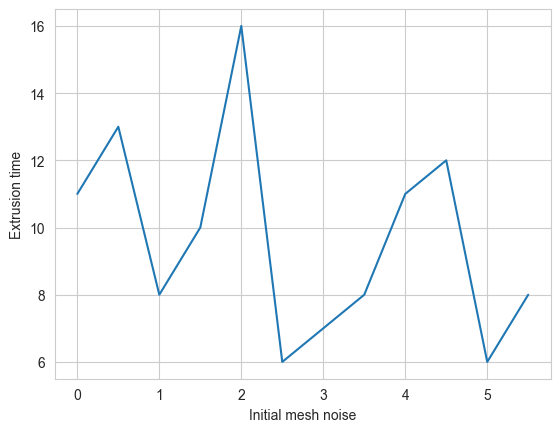

In [26]:
plt.plot(noise_vec,extrusion_times)
plt.ylabel('Extrusion time'); plt.xlabel('Initial mesh noise')
print(extrusion_times)

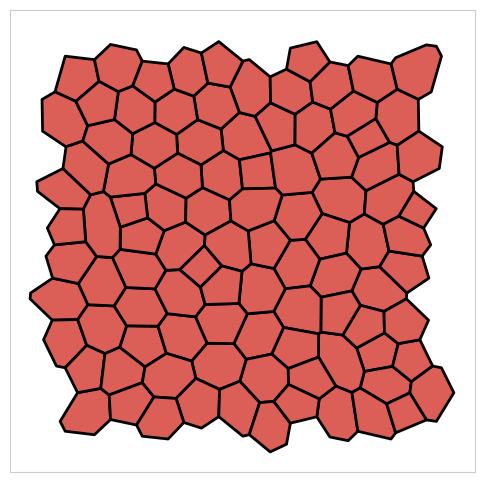

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:

i=0
hh = simulations[5][i]
for cells in hh:
    #ids_nofronter = [1,15,30,6,98, 23,42,56,68,71]
    #cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_nofronter])[1]] = 1
    cells.properties['color'] = definecolors(cells)
    cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #ids_Gamma0 = [1,15,30,6,98,23,42,56,68,71]
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_Gamma0])[1]] = 1
# definition of the frame for the interactive video
history_10_plot = hh[0:40]#+history1
fig=plt.figure()
fig.set_size_inches(6,6);
ax = fig.gca()
# initialization function: plot the background of each frame
def init_fig():
    ax = plt.figure();
    return (ax,)
# animation function. This is called sequentially
def animate_fig(i):
    cells_array=history_10_plot
    v_max = np.max((np.max(cells_array[-1].mesh.vertices), np.max(cells_array[0].mesh.vertices)))
    size = 2.0*v_max
    cells= history_10_plot[i]
    return model.draw(cells,ax,size)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,animate_fig, init_func=init_fig,
                               frames=(len(history_10_plot)))
HTML(anim.to_html5_video())